Генетический алгоритм

P.S. если не разберетесь куда тыкать пишите! А так просто нажимать на ячейки, как на рисуночке ниже


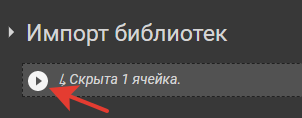

Импорт библиотек и дополнительные функции просто запустить, параметры комнаты и её отрисовку запустить и посмотреть, а генетический алгоритм - запустить, почитать и посмотреть

## Импорт библиотек

In [21]:
import numpy as np
import random as random
from sklearn.preprocessing import StandardScaler

import matplotlib.path as pltPath
import plotly.graph_objects as go

## Дополнительные функции

In [22]:
def createRoom(xcoord, ycoord):
    '''
    определение комнаты по заданным координатам
    :param ncorners:
    :param xcoord:
    :param ycoord:
    :return:
    '''
    ncorners = len(xcoord)
    room = np.zeros((ncorners, 2))
    for corner in range(ncorners):
        room[corner, 0] = xcoord[corner]
        room[corner, 1] = ycoord[corner]
    return room


def findMinMaxRoom(xcoord, ycoord):
    '''
    опеределение минимальных и максимальных размеров комнаты
    :param xcoord:
    :param ycoord:
    :return:
    '''
    return min(xcoord), max(xcoord), min(ycoord), max(ycoord)


def createPoints(stepx, stepy, xcoord, ycoord):
    '''
    формирование массивов внутренних и внешних точек
    :param stepx:
    :param stepy:
    :param ncorners:
    :param xcoord:
    :param ycoord:
    :return:
    '''
    ncorners = len(xcoord)
    room = createRoom(xcoord, ycoord)
    xrmin, xrmax, yrmin, yrmax = findMinMaxRoom(xcoord, ycoord)
    x = np.arange(xrmin, xrmax + stepx, stepx)
    y = np.arange(yrmin, yrmax + stepy, stepy)
    xx, yy = np.meshgrid(x, y)

    path = pltPath.Path(room)

    points = []

    for i in range(len(xx)):
        for j in range(len(xx[i])):
            points.append([xx[i][j], yy[i][j]])

    inside2 = path.contains_points(points)

    pointsIn = []
    pointsOut = []

    for i in range(len(inside2)):
        flag = 0
        if inside2[i]:
            for j in range(len(room)):
                xc1, yc1 = room[j]
                if j != (ncorners - 1):
                    xc2, yc2 = room[j + 1]
                else:
                    xc2, yc2 = room[0]

                x, y = points[i]

                k1 = abs(xc1 - xc2)
                k2 = abs(yc1 - yc2)
                s1 = np.sqrt(k1 * k2 + k2 * k2)

                k1 = abs(xc1 - x)
                k2 = abs(yc1 - y)
                s2 = np.sqrt(k1 * k2 + k2 * k2)

                k1 = abs(xc2 - x)
                k2 = abs(yc2 - y)
                s3 = np.sqrt(k1 * k2 + k2 * k2)

                s1 = np.round(s1 * 1e4) / 1e-4
                s2 = s2 + s3
                s2 = np.round(s2 * 1e4) / 1e-4

                if s2 == s1:
                    flag = 1

            if flag == 1:
                pointsOut.append(points[i])
            else:
                pointsIn.append(points[i])

        else:
            pointsOut.append(points[i])

    pointsIn = np.array(pointsIn)
    pointsOut = np.array(pointsOut)

    return pointsIn, pointsOut


def standardScalerPoints(xcoord, ycoord, pointsIn, pointsOut):
    '''
    стандартизация данных
    :param xcoord:
    :param ycoord:
    :param pointsIn:
    :param pointsOut:
    :return:
    '''
    scaler = StandardScaler()
    room = createRoom(xcoord, ycoord)
    roomScaler = scaler.fit_transform(room.reshape(-1, 1))
    roomScaler = roomScaler.reshape(len(room), 2)

    pointsInScaler = scaler.transform(pointsIn.reshape(-1, 1))
    pointsInScaler = pointsInScaler.reshape(len(pointsIn), 2)
    pointsOutScaler = scaler.transform(pointsOut.reshape(-1, 1))
    pointsOutScaler = pointsOutScaler.reshape(len(pointsOut), 2)

    return roomScaler, pointsInScaler, pointsOutScaler, scaler


def createCoordAnchors(nanchors, xcoord, ycoord):
    '''
    генерировние координат маяков
    :param nanchors:
    :param xcoord:
    :param ycoord:
    :return:
    '''
    xrmin, xrmax, yrmin, yrmax = findMinMaxRoom(xcoord, ycoord)
    coordAnchors = np.zeros((nanchors, 2))
    for anchor in range(nanchors):
        coordAnchors[anchor, 0] = random.uniform(xrmin, xrmax)
        coordAnchors[anchor, 1] = random.uniform(yrmin, yrmax)
    return coordAnchors


def polyDistPoint(xanchor, yanchor, xcoord, ycoord):
    '''
    сдвигать маяки на границы комнаты, если они вылетели за её пределы
    :param xanchor:
    :param yanchor:
    :param xcoord:
    :param ycoord:
    :return:
    '''

    if (xcoord[0] != xcoord[-1]) or (ycoord[0] != ycoord[-1]):
        xcoord = np.append(xcoord, xcoord[0])
        ycoord = np.append(ycoord, ycoord[0])

    A = -np.diff(ycoord)
    B = np.diff(xcoord)
    C = ycoord[1:] * xcoord[:-1] - xcoord[1:] * ycoord[:-1]

    AB = 1 / (A ** 2 + B ** 2)
    vv = (A * xanchor + B * yanchor + C) - 1e-3
    xpoint = xanchor - (A * AB) * vv
    ypoint = yanchor - (B * AB) * vv

    idx_x = (((xpoint >= xcoord[:-1]) & (xpoint <= xcoord[1:])) | ((xpoint >= xcoord[1:]) & (xpoint <= xcoord[:-1])))
    idx_y = (((ypoint >= ycoord[:-1]) & (ypoint <= ycoord[1:])) | ((ypoint >= ycoord[1:]) & (ypoint <= ycoord[:-1])))
    idx = idx_x & idx_y

    dcoord = np.sqrt((xcoord[:-1] - xanchor) ** 2 + (ycoord[:-1] - yanchor) ** 2)

    if not any(idx):
        i = np.argmin(dcoord)
        xpoly = xcoord[i]
        ypoly = ycoord[i]
    else:
        dpoint = np.sqrt((xpoint[idx] - xanchor) ** 2 + (ypoint[idx] - yanchor) ** 2)
        i_coord = np.argmin(dcoord)
        i_point = np.argmin(dpoint)
        i = np.argmin([i_coord, i_point])
        if i == 0:
            xpoly = xpoint[i_coord]
            ypoly = ypoint[i_coord]
        elif i == 1:
            idxs = np.where(idx)[0]
            xpoly = xpoint[idxs[i_point]]
            ypoly = ypoint[idxs[i_point]]

    return xpoly, ypoly


def polyCoordAnchors(xcoord, ycoord, room, coordAnchors):
    polyCoordAnchor = np.zeros(coordAnchors.shape)
    path = pltPath.Path(room)
    for i, coordAnchor in enumerate(coordAnchors):
        inside = path.contains_points(coordAnchor.reshape((1, 2)))
        if not inside:
            xpoly, ypoly = polyDistPoint(coordAnchor[0], coordAnchor[1], xcoord, ycoord)
            polyCoordAnchor[i] = [xpoly, ypoly]
        else:
            polyCoordAnchor[i] = coordAnchor
    return polyCoordAnchor


def segmentCrossing(room, pointInMetka, coordAnchor):
    '''
    ставится flag метке, сколько маяков видит метку
    0 - пересечений нет, маяк видит метку
    1 - есть одно пересечение, маяк не видит метку
    :param room:
    :param pointInMetka:
    :param coordAnchor:
    :return:
    '''
    flag = 0
    ncorners = len(room)

    x1_1, y1_1 = coordAnchor
    x1_2, y1_2 = pointInMetka

    A1 = y1_1 - y1_2
    B1 = x1_2 - x1_1
    C1 = x1_1 * y1_2 - x1_2 * y1_1

    def point(x, y):
        if min(x1_1, x1_2) <= x <= max(x1_1, x1_2) and min(y1_1, y1_2) <= y <= max(y1_1, y1_2):
            flag = 1
        else:
            flag = 0
        return flag

    for j in range(ncorners):

        x2_1, y2_1 = room[j]
        if j != (ncorners - 1):
            x2_2, y2_2 = room[j + 1]
        else:
            x2_2, y2_2 = room[0]

        A2 = y2_1 - y2_2
        B2 = x2_2 - x2_1
        C2 = x2_1 * y2_2 - x2_2 * y2_1

        if B1 * A2 - B2 * A1 and A1:
            y = (C2 * A1 - C1 * A2) / (B1 * A2 - B2 * A1)
            x = (-C1 - B1 * y) / A1
            flag += point(x, y)
        elif B1 * A2 - B2 * A1 and A2:
            y = (C2 * A1 - C1 * A2) / (B1 * A2 - B2 * A1)
            x = (-C2 - B2 * y) / A2
            flag += point(x, y)
        else:
            flag += 0
    return flag


def estimateDOP(room, pointsIn, coordAnchors, nanchors, DOPmax=20):
    '''
    расчет геометрического фактора
    :param room:
    :param pointsIn:
    :param coordAnchors:
    :param nanchors:
    :param DOPmax:
    :return:
    '''
    DOP = np.zeros(len(pointsIn))
    DOP += DOPmax

    for point, pointIn in enumerate(pointsIn):
        rastMatrix = np.zeros(nanchors)
        gradMatrix = np.zeros((nanchors, 2))
        flagAnchor = 0

        for anchor, coordAnchor in enumerate(coordAnchors):
            flag = segmentCrossing(room, coordAnchor, pointIn)

            if flag == 0:
                flagAnchor += 1
                rastMatrix[anchor] = np.sqrt((pointIn[0] - coordAnchor[0]) ** 2 + (pointIn[1] - coordAnchor[1]) ** 2)
                gradMatrix[anchor] = (pointIn - coordAnchor) / rastMatrix[anchor]

            if flagAnchor >= 3:
                DOP[point] = np.sqrt(np.trace(np.linalg.inv(gradMatrix.T.dot(gradMatrix))))

    return DOP


def getSurvPopul(popul, val, nsurv, reverse):
    '''
    функция получения популяции
    :param popul:
    :param val:
    :param nsurv:
    :param reverse:
    :return:
    '''
    newPopul = []
    sval = sorted(val, reverse=reverse)
    for i in range(nsurv):
        index = val.index(sval[i])
        newPopul.append(popul[index])
    return newPopul, sval


def getParents(currPopul, nsurv):
    '''
    функция получения родителей
    :param currPopul:
    :param nsurv:
    :return:
    '''
    indexp1 = random.randint(0, nsurv - 1)
    indexp2 = random.randint(0, nsurv - 1)
    botp1 = currPopul[indexp1]
    botp2 = currPopul[indexp2]
    return botp1, botp2


def crossPointFrom2Parents(botp1, botp2, idx):
    '''
    функция смешивания (кроссинговера) двух родителей
    :param botp1:
    :param botp2:
    :param idx:
    :return:
    '''
    pindex = random.random()
    if pindex < 0.5:
        x = botp1[idx]
    else:
        x = botp2[idx]
    return x


def getParentsN(nParentReproduct, currPopul, nsurv):
    '''
    функция получения родителей
    :param nParentReproduct:
    :param currPopul:
    :param nsurv:
    :return: parents
    '''
    parents = []
    nsurvi = [i for i in range(nsurv)]
    for parent in range(nParentReproduct):
        indexp = random.choice(nsurvi)
        parents.append(currPopul[indexp])
        nsurvi.remove(indexp)
    return parents


def geneReplace(skoGenesReplace, skoCoordVariation, bot, nanchors):
    '''
    мутация бота удаление/вставка старого гена новым
    :param skoGenesReplace:
    :param skoCoordVariation:
    :param bot:
    :param nanchors:
    :return: bot:
    '''
    genesReplace = abs(round(skoGenesReplace * np.random.randn()))
    if genesReplace > 0:
        for genes in range(genesReplace):
            indexReplace = random.randint(0, nanchors * 2 - 1)
            bot.reshape(nanchors * 2)[indexReplace] += skoCoordVariation * np.random.randn()
    return bot


def geneExchange(skoChangeGenes, bot, nanchors):
    '''
    мутация бота внутри - замена генов
    :param skoChangeGenes:
    :param bot:
    :param nanchors:
    :return: bot
    '''
    genesChange = abs(round(skoChangeGenes * np.random.randn()))
    if genesChange > 0:
        for genes in range(genesChange):
            while 1:
                index1 = random.randint(0, nanchors * 2 - 1)
                index2 = random.randint(0, nanchors * 2 - 1)
                if index1 != index2:
                    break
            value1 = bot.reshape(nanchors * 2)[index1]
            value2 = bot.reshape(nanchors * 2)[index2]
            bot.reshape(nanchors * 2)[index1] = value2
            bot.reshape(nanchors * 2)[index2] = value1
    return bot


def crossPointFromNParents(nParentReproduct, parents, nanchors):
    '''
    равномерное размножение родителей
    :param nParentReproduct:
    :param parents:
    :param nanchors:
    :return: bot
    '''
    bot = np.zeros(nanchors * 2)
    for i in range(nanchors * 2):
        idx = random.randint(0, nParentReproduct - 1)
        parent = parents[idx].reshape(nanchors * 2)
        bot[i] = parent[i]
    return bot.reshape((nanchors, 2))


def partPointFromNParents(nParentReproduct, parents, nanchors, nPartPoints):
    '''
    размножение с разрывом хромосом
    :param nParentReproduct:
    :param parents:
    :param nanchors:
    :param nPartPoints:
    :return: bot
    '''
    bot = np.zeros(nanchors * 2)

    def partDivision(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i: i + n]

    partGenes = list(partDivision([i for i in range(nanchors * 2)], round(nanchors * 2 / (nPartPoints + 1))))
    for part in partGenes:
        idx = random.randint(0, nParentReproduct - 1)
        parent = parents[idx].reshape(nanchors * 2)
        bot[part] = parent[part]
    return bot.reshape((nanchors, 2))


def plotRoom(room, pointsIn, pointsOut):
    roomPlot = list(room).copy()
    roomPlot.append(roomPlot[0])
    xr, yr = zip(*roomPlot)

    xin, yin = pointsIn[:, 0], pointsIn[:, 1]
    xout, yout = pointsOut[:, 0], pointsOut[:, 1]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=xr, y=yr,
                             mode='lines',
                             name='path'))
    fig.add_trace(go.Scatter(x=xin, y=yin,
                             mode='markers',
                             name='points in path'))

    fig.add_trace(go.Scatter(x=xout, y=yout,
                             mode='markers', name='points out path'))

    fig.show()


def plotAnchors(coordAnchors, room):
    roomPlot = list(room).copy()
    roomPlot.append(roomPlot[0])
    xr, yr = zip(*roomPlot)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=xr, y=yr,
                             mode='lines',
                             name='path'))
    fig.add_trace(go.Scatter(x=coordAnchors[:, 0], y=coordAnchors[:, 1],
                             mode='markers',
                             name='coord mayak'))

    fig.show()


def plotDOPfactor(rooms, coordMayak, DOP, pointsInMetka):
    rooms_plot = list(rooms).copy()
    rooms_plot.append(rooms_plot[0])
    xr, yr = zip(*rooms_plot)

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=xr, y=yr, z=np.zeros(len(xr)),
                               mode='lines',
                               name="rooms"))

    fig.add_trace(go.Mesh3d(x=(pointsInMetka[:, 0]),
                            y=(pointsInMetka[:, 1]),
                            z=DOP,
                            opacity=0.7,
                            color='blue',
                            name='DOP'
                            ))

    fig.add_trace(go.Scatter3d(x=coordMayak[:, 0],
                               y=coordMayak[:, 1],
                               z=np.zeros(len(coordMayak)),
                               mode='markers',
                               name='coord mayak'
                               ))

    fig.show()

## Параметры комнаты и её отрисовка

In [23]:
# задаем число маяков
nanchors = 4

# число углов комнаты
ncorners = 4

# шаг сетки
stepx = 0.1
stepy = 0.1

# массив координат по х и y
xcoord = np.array((0.5, 3.5, 3.5, 0.5))
ycoord = np.array((0.5, 0.5, 3.5, 3.5))

In [24]:
# формируем комнату
room = createRoom(xcoord, ycoord)

# формируем точки внутри помещения
pointsIn, pointsOut = createPoints(stepx, stepy, xcoord, ycoord)

# нормировка комнаты
roomScaler, pointsInScaler, pointsOutScaler, scaler = standardScalerPoints(xcoord, ycoord, pointsIn, pointsOut)

# нормировка по координатам
xcoordScaler = roomScaler[:, 0]
ycoordScaler = roomScaler[:, 1]

In [25]:
# генерируем координаты маяков
coordAnchorsScaler = createCoordAnchors(nanchors, xcoordScaler, ycoordScaler)

# расчет геометрического фактора
DOP = estimateDOP(roomScaler, pointsInScaler, coordAnchorsScaler, nanchors, DOPmax=30)

In [26]:
# построение комнаты
plotRoom(roomScaler, pointsInScaler, pointsOutScaler)
plotAnchors(coordAnchorsScaler, roomScaler)
plotDOPfactor(roomScaler, coordAnchorsScaler, DOP, pointsInScaler)

## Генетический алгоритм

Все свободные параметры генетического алгоритма из файла task

In [27]:
# initPopulSize = # M0 начальная численность популяции
# estPopulSize =  #Must установившаяся численность популяции
# ratePopulDecline =  #  параметр скорости снижения численности популяции

# initDescendSie = # начальная численность потомков
# estDescendSize = # установившаяся численность потомков
# rateDescendDecline = # параметр скорости снижения численности потомков

# rateSwitchParent = # параметр скорости переключения между алгоритмом подбора родителей
# nParentReproduct = # число особей родителей участвующих при в размножении
# nChromosomBreakPoints = # число точек разрыва хромосомы при размножении
# nDescendReproduct = # число потомков в одном размножении
# skoGenesReplace = # ско чила заменяемых генов
# skoCoordVariation = # ско вариации координаты
# skoInterchangeGenes = # ско числа обменивающихся пар генов

# initProbabSelectAlg = # четыре начальные вероятности вариантов алгоритма отбора
# probab1 =
# probab2 =
# probab3 =
# probab4 =

# rateChangeSelectAlg = # параметр скорости изменения вероятности включения вариантов алгоритмов отбора
# redIncProbabSelectAlg = # параметр включения снижения / повышения вероятностей вариантов алгоритмов отбора
# thresholdAlgDisp = # порог алгоритма отбора усечением
# shareElitSelect = # доля элитных особей в элитарном отборе
# toleranceCoeffDisp = # коэффициент терпимости к ухудшению показателя качества алгоритма отбора вытеснением
# rateCoolingAlgAnn = # параметр скорости остыания в алгоритме отбора методом отжига
# initTempAlgAnn = # начальное значение температуры в алгоритме отбора методом отжига
# estTempAlgAnn = # установившееся значение температуры в алгоритме отбора методом отжига

Параметры, которые сейчас используются в генетическом алгоритме

### Пункт 1. Численность особей и число новых потомков на отдельной итерации

In [28]:
initPopulSize = 0 # M0 начальная численность популяции
estPopulSize =  50 # Must установившаяся численность популяции
ratePopulDecline = 1e-1 #  параметр скорости снижения численности популяции

initDescendSie = 0 # начальная численность потомков
estDescendSize = 40 # установившаяся численность потомков
rateDescendDecline = 1e-1 # параметр скорости снижения численности потомков

#### Вопрос по реализации алгоритма для расчета численности особей и числа потомков

In [29]:
# как именно задаются параметры
# M_k=[M_уст+(M_уст-M_0 )  exp⁡(-αk) ]_округл, - формула из документа

# если считаем, что начальная числинность равна 100, то численность увеличивается
initPopulSize = 100 # M0 начальная численность популяции
estPopulSize =  50 # Must установившаяся численность популяции
ratePopulDecline = 1e-1 #  параметр скорости снижения численности популяции

for it in range(50):
  print(round(estPopulSize + (estPopulSize - initPopulSize) * np.exp(-ratePopulDecline * it)))

0
5
9
13
16
20
23
25
28
30
32
33
35
36
38
39
40
41
42
43
43
44
44
45
45
46
46
47
47
47
48
48
48
48
48
48
49
49
49
49
49
49
49
49
49
49
49
50
50
50


In [30]:
# если считаем, что начальная числинность равна 0, то действительно численность уменьшается
initPopulSize = 0 # M0 начальная численность популяции
estPopulSize =  50 # Must установившаяся численность популяции
ratePopulDecline = 1e-1 #  параметр скорости снижения численности популяции

for it in range(50):
  print(round(estPopulSize + (estPopulSize - initPopulSize) * np.exp(-ratePopulDecline * it)))

100
95
91
87
84
80
77
75
72
70
68
67
65
64
62
61
60
59
58
57
57
56
56
55
55
54
54
53
53
53
52
52
52
52
52
52
51
51
51
51
51
51
51
51
51
51
51
50
50
50


### Пункт 2. Размножение

Сейчас реализован 1) равновероятный отбор родителей

Число особей-родителей Q задается входным параметром 

In [31]:
nParentReproduct = 3 # число родителей

Число точек разрыва хромосомы R тоже задается

In [32]:
nPartPoints = 3 # число точек разрыва хромосомы при размножении

Реализованы следующие способы кроссинговера/скрещивания

Равномерное скрещивание

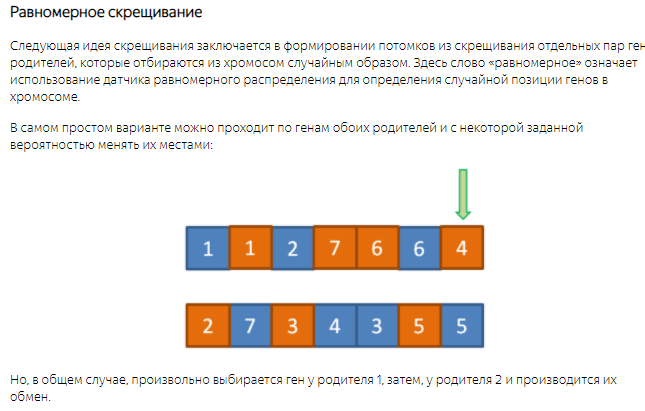

С разрывом хромосомы на несколько частей

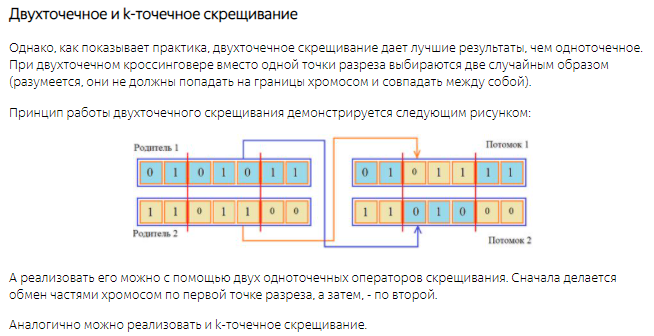

In [33]:
# задается вероятность выбора либо одного способа скрещивания либо другого
pCrossingMethod = 0.5

### Пункт 3. Мутации

Реализованы все мутации и задаются начальные параметры для мутаций

In [34]:
skoGenesReplace = 2  # ско заменяемых генов
skoCoordVariation = 0.25  # ско вариации координаты
skoChangeGenes = 1.25  # ско числа обменивающихся пар генов

### Пункт 4. Отбор особей (родителей и потомков) в новую популяцию

На данный момент задействуется алгоритм 1) усечением

### Работа генетического алгоритма

Генерируются боты по всей длине заданной популяции (один раз), далее пробегаемся по всем эпохам, считаем ДОП и добавляем в новую популяцию выживших - число лучших особей, дополняем новую популяцию потомками - число потомков = популяция - число лучших особей, переходим к следующей эпохе.

Или мы из лучших делаем потомков и лучших удаляем из популяции и заполняем новую популяцию опять случайно сгенерированными ботами?

Задаем начальные значения

In [35]:
npopul = estPopulSize * 2     # Размер популяции
nsurv = estDescendSize * 2     # Количество выживших (столько лучших переходит в новую популяцию)
nnew = npopul - nsurv # Количество новых (столько новых ботов создается)
epohs = 100   # Количество эпох

In [36]:
popul = []       # Двумерный массив популяции, размерностью [n, l]. npopyl ботов
val = []         # Одномерный массив значений этих ботов

# Проходим по всей длине популяции
for i in range(npopul):

    # Генерим случайного бота
    bot = createCoordAnchors(nanchors, xcoordScaler, ycoordScaler)
    # Проверяем не вылетел ли он за края комнаты
    bot = polyCoordAnchors(xcoordScaler, ycoordScaler, roomScaler, bot)
    # Добавляем в популяцию
    popul.append(bot)

# Пробегаемся по всем эпохам
for it in range(epohs):

    # Рассчитываем текущую численность особей - размер популяции
    npopul = round(estPopulSize + (estPopulSize - initPopulSize) * np.exp(-ratePopulDecline * it))
    # Рассчитываем текущее число потомков
    nnew = round(estDescendSize + (estDescendSize - initDescendSie) * np.exp(-rateDescendDecline * it))
    # Рассчитываем число выживших особей
    nsurv = npopul - nnew 

    # Создаем пустой список для значений ботов
    val = []

    # Проходим по всей длине популяции
    for bot in popul:
        # Берем очередного бота и рассчитываем геометрический фактор
        DOP = estimateDOP(roomScaler, pointsInScaler, bot, nanchors, DOPmax=30)
        # Считаем суммированное значение ДОП по всей площади комнаты
        val.append(sum(DOP) / len(DOP))

    # Получаем новую популяцию и сортированный список значнией, отбираем выживших
    newpopul, sval = getSurvPopul(popul, val, nsurv, 0)

    # Выводим 5 лучших ботов
    print("Значение ДОП 5 лучших ботов на ", it, "-ой эпохе ", [round(s,8) for s in sval[0:5]])

    # Строим расположение маяков в комнате
    if it % 10 == 0:
        plotAnchors(newpopul[0], roomScaler)

    # Проходимся в цикле nnew-раз, дополняем популяцию потомками
    for i in range(nnew):

        # Из newpopul(новой популяции) получаем nParentReproduct случайных родителей-ботов
        parents = getParentsN(nParentReproduct, newpopul, nsurv)

        # Выбираем способ размножения - либо равномерный, либо по частям и получаем нового бота
        prob = random.random()
        if prob < pCrossingMethod:
            bot = partPointFromNParents(nParentReproduct, parents, nanchors, nPartPoints)
        else:
            bot = crossPointFromNParents(nParentReproduct, parents, nanchors)

        # Добавляем мутации к полученному боту

        # Замена/вставка генов
        bot = geneReplace(skoGenesReplace, skoCoordVariation, bot, nanchors)

        # Мутации генов
        bot = geneExchange(skoChangeGenes, bot, nanchors)

        # Проверяем не вылетел ли бот за пределы комнаты
        newbot = polyCoordAnchors(xcoordScaler, ycoordScaler, roomScaler, bot)
        # Добавляем бота в новую популяцию к выжившим
        newpopul.append(newbot)

        # Таким образом к nsurv-лучших ботов предыдующей популяции добавится nnew-новых ботов)

    # Записываем в popul посчитанную новую популяцию
    popul = newpopul

Значение ДОП 5 лучших ботов на  0 -ой эпохе  [1.0692148, 1.07205867, 1.08527881, 1.09416617, 1.09574766]


Значение ДОП 5 лучших ботов на  1 -ой эпохе  [1.05296365, 1.05889599, 1.0692148, 1.07205867, 1.07359647]
Значение ДОП 5 лучших ботов на  2 -ой эпохе  [1.03817706, 1.04755783, 1.05124591, 1.05296365, 1.05299188]
Значение ДОП 5 лучших ботов на  3 -ой эпохе  [1.03760336, 1.03817706, 1.04755783, 1.04868878, 1.05124591]
Значение ДОП 5 лучших ботов на  4 -ой эпохе  [1.03760336, 1.03817706, 1.0409122, 1.04660065, 1.04755783]
Значение ДОП 5 лучших ботов на  5 -ой эпохе  [1.03760336, 1.03817706, 1.03950962, 1.0409122, 1.04355724]
Значение ДОП 5 лучших ботов на  6 -ой эпохе  [1.03760336, 1.03817706, 1.03828413, 1.03950962, 1.0409122]
Значение ДОП 5 лучших ботов на  7 -ой эпохе  [1.03760336, 1.03771821, 1.03785767, 1.03817706, 1.03828413]
Значение ДОП 5 лучших ботов на  8 -ой эпохе  [1.02983411, 1.03760336, 1.03760902, 1.03771821, 1.03785767]
Значение ДОП 5 лучших ботов на  9 -ой эпохе  [1.02983411, 1.03194083, 1.03610779, 1.03760336, 1.03760902]
Значение ДОП 5 лучших ботов на  10 -ой эпохе  [1.0

Значение ДОП 5 лучших ботов на  11 -ой эпохе  [1.02942551, 1.02981703, 1.02983411, 1.03003194, 1.03040307]
Значение ДОП 5 лучших ботов на  12 -ой эпохе  [1.02942551, 1.02970489, 1.02981703, 1.02983411, 1.02994334]
Значение ДОП 5 лучших ботов на  13 -ой эпохе  [1.02759873, 1.02942551, 1.02970489, 1.02971345, 1.02981703]
Значение ДОП 5 лучших ботов на  14 -ой эпохе  [1.02759873, 1.02845195, 1.0294211, 1.02942551, 1.02970489]
Значение ДОП 5 лучших ботов на  15 -ой эпохе  [1.02759873, 1.0279775, 1.02845195, 1.02934861, 1.0294211]
Значение ДОП 5 лучших ботов на  16 -ой эпохе  [1.02759873, 1.0279775, 1.02845195, 1.02933964, 1.02934861]
Значение ДОП 5 лучших ботов на  17 -ой эпохе  [1.02759873, 1.0279775, 1.02845195, 1.02933964, 1.02934861]
Значение ДОП 5 лучших ботов на  18 -ой эпохе  [1.02706823, 1.02719883, 1.02759873, 1.0279775, 1.02845195]
Значение ДОП 5 лучших ботов на  19 -ой эпохе  [1.02706823, 1.02719883, 1.02759873, 1.02785072, 1.0279775]
Значение ДОП 5 лучших ботов на  20 -ой эпохе

Значение ДОП 5 лучших ботов на  21 -ой эпохе  [1.02706823, 1.02708662, 1.02719883, 1.02742925, 1.02743884]
Значение ДОП 5 лучших ботов на  22 -ой эпохе  [1.02706823, 1.02708662, 1.02716152, 1.02717846, 1.02719883]
Значение ДОП 5 лучших ботов на  23 -ой эпохе  [1.0270071, 1.02706823, 1.02708662, 1.02715999, 1.02716152]
Значение ДОП 5 лучших ботов на  24 -ой эпохе  [1.0270071, 1.02706476, 1.02706823, 1.02708662, 1.02715999]
Значение ДОП 5 лучших ботов на  25 -ой эпохе  [1.0264435, 1.0270071, 1.02706476, 1.02706823, 1.02708662]
Значение ДОП 5 лучших ботов на  26 -ой эпохе  [1.02634809, 1.0264435, 1.0270071, 1.02706476, 1.02706823]
Значение ДОП 5 лучших ботов на  27 -ой эпохе  [1.02634809, 1.0264435, 1.0270071, 1.02706476, 1.02706823]
Значение ДОП 5 лучших ботов на  28 -ой эпохе  [1.02634809, 1.0264435, 1.0264435, 1.02672109, 1.0269635]
Значение ДОП 5 лучших ботов на  29 -ой эпохе  [1.02634809, 1.0264435, 1.0264435, 1.02651918, 1.02672109]
Значение ДОП 5 лучших ботов на  30 -ой эпохе  [1.0

Значение ДОП 5 лучших ботов на  31 -ой эпохе  [1.02634809, 1.0264435, 1.0264435, 1.02648079, 1.02651918]
Значение ДОП 5 лучших ботов на  32 -ой эпохе  [1.02634809, 1.0264435, 1.0264435, 1.02648079, 1.02648079]
Значение ДОП 5 лучших ботов на  33 -ой эпохе  [1.02634809, 1.0264435, 1.0264435, 1.02648079, 1.02648079]
Значение ДОП 5 лучших ботов на  34 -ой эпохе  [1.02634809, 1.02639704, 1.0264435, 1.0264435, 1.02648079]
Значение ДОП 5 лучших ботов на  35 -ой эпохе  [1.02634809, 1.02639704, 1.02639704, 1.0264435, 1.0264435]
Значение ДОП 5 лучших ботов на  36 -ой эпохе  [1.02627399, 1.02634809, 1.02634809, 1.02639704, 1.02639704]
Значение ДОП 5 лучших ботов на  37 -ой эпохе  [1.02627399, 1.02634809, 1.02634809, 1.02638169, 1.02639704]
Значение ДОП 5 лучших ботов на  38 -ой эпохе  [1.0262252, 1.02626001, 1.02627399, 1.02634809, 1.02634809]
Значение ДОП 5 лучших ботов на  39 -ой эпохе  [1.02618974, 1.0262252, 1.02626001, 1.02627399, 1.02634809]
Значение ДОП 5 лучших ботов на  40 -ой эпохе  [1.

Значение ДОП 5 лучших ботов на  41 -ой эпохе  [1.02608341, 1.02618974, 1.0262252, 1.02626001, 1.02626001]
Значение ДОП 5 лучших ботов на  42 -ой эпохе  [1.02608341, 1.02618974, 1.0262252, 1.02626001, 1.02626001]
Значение ДОП 5 лучших ботов на  43 -ой эпохе  [1.02607932, 1.02608341, 1.02618974, 1.02621596, 1.0262252]
Значение ДОП 5 лучших ботов на  44 -ой эпохе  [1.02581275, 1.02607932, 1.02608341, 1.02618974, 1.02621217]
Значение ДОП 5 лучших ботов на  45 -ой эпохе  [1.02581275, 1.02607932, 1.02608341, 1.02618974, 1.02621217]
Значение ДОП 5 лучших ботов на  46 -ой эпохе  [1.02581275, 1.02607932, 1.02608341, 1.02610937, 1.02618974]
Значение ДОП 5 лучших ботов на  47 -ой эпохе  [1.02581275, 1.02599715, 1.02607932, 1.02608341, 1.02610937]
Значение ДОП 5 лучших ботов на  48 -ой эпохе  [1.02581275, 1.02599715, 1.02607932, 1.02608341, 1.02610937]
Значение ДОП 5 лучших ботов на  49 -ой эпохе  [1.02581275, 1.02599715, 1.02607932, 1.02608341, 1.02608341]
Значение ДОП 5 лучших ботов на  50 -ой э

Значение ДОП 5 лучших ботов на  51 -ой эпохе  [1.02581275, 1.02599715, 1.02607932, 1.02608341, 1.02608341]
Значение ДОП 5 лучших ботов на  52 -ой эпохе  [1.02581275, 1.02599715, 1.02607932, 1.02608341, 1.02608341]
Значение ДОП 5 лучших ботов на  53 -ой эпохе  [1.02581275, 1.02591123, 1.02599715, 1.02607932, 1.02607932]
Значение ДОП 5 лучших ботов на  54 -ой эпохе  [1.02581275, 1.02591123, 1.02599715, 1.02605863, 1.02607932]
Значение ДОП 5 лучших ботов на  55 -ой эпохе  [1.02581275, 1.02591123, 1.02599715, 1.02605863, 1.02607932]
Значение ДОП 5 лучших ботов на  56 -ой эпохе  [1.02581275, 1.02591123, 1.02599715, 1.02605863, 1.02607932]
Значение ДОП 5 лучших ботов на  57 -ой эпохе  [1.02581275, 1.02591123, 1.02599715, 1.02605863, 1.02607932]
Значение ДОП 5 лучших ботов на  58 -ой эпохе  [1.02581275, 1.02581275, 1.02591123, 1.02599715, 1.02605863]
Значение ДОП 5 лучших ботов на  59 -ой эпохе  [1.02581275, 1.02581275, 1.02591123, 1.02599715, 1.02605047]
Значение ДОП 5 лучших ботов на  60 -о

Значение ДОП 5 лучших ботов на  61 -ой эпохе  [1.02581275, 1.02581275, 1.02591123, 1.02599715, 1.02601749]
Значение ДОП 5 лучших ботов на  62 -ой эпохе  [1.02581275, 1.02581275, 1.02590707, 1.02591123, 1.02599169]
Значение ДОП 5 лучших ботов на  63 -ой эпохе  [1.02581275, 1.02581275, 1.02590707, 1.02591123, 1.02599169]
Значение ДОП 5 лучших ботов на  64 -ой эпохе  [1.02570279, 1.02581275, 1.02581275, 1.02590707, 1.02591123]
Значение ДОП 5 лучших ботов на  65 -ой эпохе  [1.02565226, 1.02570279, 1.02579817, 1.02581275, 1.02581275]
Значение ДОП 5 лучших ботов на  66 -ой эпохе  [1.02565226, 1.02570279, 1.02579817, 1.02581275, 1.02581275]
Значение ДОП 5 лучших ботов на  67 -ой эпохе  [1.02565226, 1.02570279, 1.02579817, 1.02579817, 1.02581275]
Значение ДОП 5 лучших ботов на  68 -ой эпохе  [1.02565226, 1.02570279, 1.02572448, 1.02577584, 1.02579817]
Значение ДОП 5 лучших ботов на  69 -ой эпохе  [1.02565226, 1.02570279, 1.02572212, 1.02572448, 1.02577584]
Значение ДОП 5 лучших ботов на  70 -о

Значение ДОП 5 лучших ботов на  71 -ой эпохе  [1.02565226, 1.02565738, 1.02570279, 1.02572212, 1.02572448]
Значение ДОП 5 лучших ботов на  72 -ой эпохе  [1.0255644, 1.02565226, 1.02565738, 1.02565738, 1.02570279]
Значение ДОП 5 лучших ботов на  73 -ой эпохе  [1.0255644, 1.02565226, 1.02565738, 1.02565738, 1.02566543]
Значение ДОП 5 лучших ботов на  74 -ой эпохе  [1.0255644, 1.02565226, 1.02565738, 1.02565738, 1.02565738]
Значение ДОП 5 лучших ботов на  75 -ой эпохе  [1.0255149, 1.0255149, 1.0255644, 1.02565226, 1.02565738]
Значение ДОП 5 лучших ботов на  76 -ой эпохе  [1.0255149, 1.0255149, 1.0255644, 1.02565226, 1.02565504]
Значение ДОП 5 лучших ботов на  77 -ой эпохе  [1.02549294, 1.0255149, 1.0255149, 1.0255149, 1.0255644]
Значение ДОП 5 лучших ботов на  78 -ой эпохе  [1.02549294, 1.0255149, 1.0255149, 1.0255149, 1.0255644]
Значение ДОП 5 лучших ботов на  79 -ой эпохе  [1.02549294, 1.0255149, 1.0255149, 1.0255149, 1.0255149]
Значение ДОП 5 лучших ботов на  80 -ой эпохе  [1.02536457,

Значение ДОП 5 лучших ботов на  81 -ой эпохе  [1.02534948, 1.02536457, 1.02536457, 1.0254685, 1.02549294]
Значение ДОП 5 лучших ботов на  82 -ой эпохе  [1.02534948, 1.02536457, 1.02536457, 1.02536457, 1.0254685]
Значение ДОП 5 лучших ботов на  83 -ой эпохе  [1.02513301, 1.02534948, 1.02536457, 1.02536457, 1.02536457]
Значение ДОП 5 лучших ботов на  84 -ой эпохе  [1.02513301, 1.02534948, 1.02536457, 1.02536457, 1.02536457]
Значение ДОП 5 лучших ботов на  85 -ой эпохе  [1.02513301, 1.02534948, 1.02536457, 1.02536457, 1.02536457]
Значение ДОП 5 лучших ботов на  86 -ой эпохе  [1.02505145, 1.02513301, 1.02519924, 1.02522281, 1.02533646]
Значение ДОП 5 лучших ботов на  87 -ой эпохе  [1.02505145, 1.02513301, 1.02519924, 1.02522281, 1.02533646]
Значение ДОП 5 лучших ботов на  88 -ой эпохе  [1.02505145, 1.02505145, 1.02513301, 1.02513301, 1.02519924]
Значение ДОП 5 лучших ботов на  89 -ой эпохе  [1.02473898, 1.02479218, 1.02505145, 1.02505145, 1.02513301]
Значение ДОП 5 лучших ботов на  90 -ой 

Значение ДОП 5 лучших ботов на  91 -ой эпохе  [1.02473898, 1.02479218, 1.02505145, 1.02505145, 1.02513301]
Значение ДОП 5 лучших ботов на  92 -ой эпохе  [1.02464039, 1.02473898, 1.02479218, 1.02505145, 1.02505145]
Значение ДОП 5 лучших ботов на  93 -ой эпохе  [1.02464039, 1.02471061, 1.02473898, 1.0247695, 1.02479218]
Значение ДОП 5 лучших ботов на  94 -ой эпохе  [1.0246115, 1.02464039, 1.02464039, 1.02464039, 1.02471061]
Значение ДОП 5 лучших ботов на  95 -ой эпохе  [1.02448003, 1.02455475, 1.0246115, 1.02464039, 1.02464039]
Значение ДОП 5 лучших ботов на  96 -ой эпохе  [1.02448003, 1.02455475, 1.0246115, 1.02462595, 1.02464039]
Значение ДОП 5 лучших ботов на  97 -ой эпохе  [1.02448003, 1.02449688, 1.02455475, 1.02455475, 1.02460742]
Значение ДОП 5 лучших ботов на  98 -ой эпохе  [1.02421524, 1.02421524, 1.02431686, 1.02448003, 1.02449688]
Значение ДОП 5 лучших ботов на  99 -ой эпохе  [1.02421524, 1.02421524, 1.02421524, 1.02431686, 1.02442721]


## Другая конфигурация помещения

In [37]:
# задаем число маяков
nanchors = 4

# число углов комнаты
ncorners = 4

# шаг сетки
stepx = 0.1
stepy = 0.1

# массив координат по х и y
xcoord = np.array((0.5, 4.5, 3.5, 1.5))
ycoord = np.array((1.5, 2.5, 4.5, 5.5))

# формируем комнату
room = createRoom(xcoord, ycoord)

# формируем точки внутри помещения
pointsIn, pointsOut = createPoints(stepx, stepy, xcoord, ycoord)

# нормировка комнаты
roomScaler, pointsInScaler, pointsOutScaler, scaler = standardScalerPoints(xcoord, ycoord, pointsIn, pointsOut)

# нормировка по координатам
xcoordScaler = roomScaler[:, 0]
ycoordScaler = roomScaler[:, 1]

# генерируем координаты маяков
coordAnchorsScaler = createCoordAnchors(nanchors, xcoordScaler, ycoordScaler)

# расчет геометрического фактора
DOP = estimateDOP(roomScaler, pointsInScaler, coordAnchorsScaler, nanchors, DOPmax=30)

# построение комнаты
plotRoom(roomScaler, pointsInScaler, pointsOutScaler)
plotAnchors(coordAnchorsScaler, roomScaler)
plotDOPfactor(roomScaler, coordAnchorsScaler, DOP, pointsInScaler)

In [38]:
npopul = estPopulSize * 2     # Размер популяции
nsurv = estDescendSize * 2     # Количество выживших (столько лучших переходит в новую популяцию)
nnew = npopul - nsurv # Количество новых (столько новых ботов создается)
epohs = 100   # Количество эпох

In [20]:
popul = []       # Двумерный массив популяции, размерностью [n, l]. npopyl ботов
val = []         # Одномерный массив значений этих ботов

# Проходим по всей длине популяции
for i in range(npopul):

    # Генерим случайного бота
    bot = createCoordAnchors(nanchors, xcoordScaler, ycoordScaler)
    # Проверяем не вылетел ли он за края комнаты
    bot = polyCoordAnchors(xcoordScaler, ycoordScaler, roomScaler, bot)
    # Добавляем в популяцию
    popul.append(bot)

# Пробегаемся по всем эпохам
for it in range(epohs):

    # Рассчитываем текущую численность особей - размер популяции
    npopul = round(estPopulSize + (estPopulSize - initPopulSize) * np.exp(-ratePopulDecline * it))
    # Рассчитываем текущее число потомков
    nnew = round(estDescendSize + (estDescendSize - initDescendSie) * np.exp(-rateDescendDecline * it))
    # Рассчитываем число выживших особей
    nsurv = npopul - nnew 

    # Создаем пустой список для значений ботов
    val = []

    # Проходим по всей длине популяции
    for bot in popul:
        # Берем очередного бота и рассчитываем геометрический фактор
        DOP = estimateDOP(roomScaler, pointsInScaler, bot, nanchors, DOPmax=30)
        # Считаем суммированное значение ДОП по всей площади комнаты
        val.append(sum(DOP) / len(DOP))

    # Получаем новую популяцию и сортированный список значнией, отбираем выживших
    newpopul, sval = getSurvPopul(popul, val, nsurv, 0)

    # Выводим 5 лучших ботов
    print("Значение ДОП 5 лучших ботов на ", it, "-ой эпохе ", [round(s,8) for s in sval[0:5]])

    # Строим расположение маяков в комнате
    if it % 10 == 0:
        plotAnchors(newpopul[0], roomScaler)

    # Проходимся в цикле nnew-раз, дополняем популяцию потомками
    for i in range(nnew):

        # Из newpopul(новой популяции) получаем nParentReproduct случайных родителей-ботов
        parents = getParentsN(nParentReproduct, newpopul, nsurv)

        # Выбираем способ размножения - либо равномерный, либо по частям и получаем нового бота
        prob = random.random()
        if prob < pCrossingMethod:
            bot = partPointFromNParents(nParentReproduct, parents, nanchors, nPartPoints)
        else:
            bot = crossPointFromNParents(nParentReproduct, parents, nanchors)

        # Добавляем мутации к полученному боту

        # Замена/вставка генов
        bot = geneReplace(skoGenesReplace, skoCoordVariation, bot, nanchors)

        # Мутации генов
        bot = geneExchange(skoChangeGenes, bot, nanchors)

        # Проверяем не вылетел ли бот за пределы комнаты
        newbot = polyCoordAnchors(xcoordScaler, ycoordScaler, roomScaler, bot)
        # Добавляем бота в новую популяцию к выжившим
        newpopul.append(newbot)

        # Таким образом к nsurv-лучших ботов предыдующей популяции добавится nnew-новых ботов)

    # Записываем в popul посчитанную новую популяцию
    popul = newpopul

Значение ДОП 5 лучших ботов на  0 -ой эпохе  [1.05923414, 1.05965881, 1.07845052, 1.08288759, 1.08321427]


Значение ДОП 5 лучших ботов на  1 -ой эпохе  [1.0531232, 1.05923414, 1.05965881, 1.06306666, 1.06307181]
Значение ДОП 5 лучших ботов на  2 -ой эпохе  [1.04516262, 1.0531232, 1.05923414, 1.05965881, 1.06306666]
Значение ДОП 5 лучших ботов на  3 -ой эпохе  [1.04516262, 1.0531232, 1.05318174, 1.05719293, 1.05923414]
Значение ДОП 5 лучших ботов на  4 -ой эпохе  [1.04516262, 1.0531232, 1.05318174, 1.05719293, 1.05923414]
Значение ДОП 5 лучших ботов на  5 -ой эпохе  [1.04022659, 1.04516262, 1.04654527, 1.0531232, 1.05318174]
Значение ДОП 5 лучших ботов на  6 -ой эпохе  [1.04022659, 1.04083276, 1.04338566, 1.04516262, 1.04654527]
Значение ДОП 5 лучших ботов на  7 -ой эпохе  [1.03497754, 1.04022659, 1.04083276, 1.04275571, 1.04338566]
Значение ДОП 5 лучших ботов на  8 -ой эпохе  [1.03497754, 1.03956089, 1.04022659, 1.04083276, 1.04275571]
Значение ДОП 5 лучших ботов на  9 -ой эпохе  [1.03497754, 1.03956089, 1.04022659, 1.04083276, 1.04083457]
Значение ДОП 5 лучших ботов на  10 -ой эпохе  [1.03

Значение ДОП 5 лучших ботов на  11 -ой эпохе  [1.03266034, 1.03277952, 1.03497754, 1.03616984, 1.03956089]
Значение ДОП 5 лучших ботов на  12 -ой эпохе  [1.03266034, 1.03277952, 1.03497754, 1.03616984, 1.03956089]
Значение ДОП 5 лучших ботов на  13 -ой эпохе  [1.03266034, 1.03277952, 1.03497754, 1.03610284, 1.03616984]
Значение ДОП 5 лучших ботов на  14 -ой эпохе  [1.03266034, 1.03277952, 1.03365333, 1.03497754, 1.03610284]
Значение ДОП 5 лучших ботов на  15 -ой эпохе  [1.03266034, 1.03277952, 1.03330855, 1.03365333, 1.03464661]
Значение ДОП 5 лучших ботов на  16 -ой эпохе  [1.03266034, 1.03277952, 1.03330855, 1.03365333, 1.03464661]
Значение ДОП 5 лучших ботов на  17 -ой эпохе  [1.03266034, 1.03277952, 1.03330855, 1.03365333, 1.03464661]
Значение ДОП 5 лучших ботов на  18 -ой эпохе  [1.03205063, 1.03266034, 1.03277952, 1.03330855, 1.03344511]
Значение ДОП 5 лучших ботов на  19 -ой эпохе  [1.03205063, 1.03266034, 1.03277952, 1.03330855, 1.03344511]
Значение ДОП 5 лучших ботов на  20 -о

Значение ДОП 5 лучших ботов на  21 -ой эпохе  [1.03205063, 1.03261504, 1.03266034, 1.03277952, 1.03330855]
Значение ДОП 5 лучших ботов на  22 -ой эпохе  [1.02962409, 1.03170122, 1.03205063, 1.03261504, 1.03266034]
Значение ДОП 5 лучших ботов на  23 -ой эпохе  [1.02962409, 1.03170122, 1.03189967, 1.03205063, 1.03261504]
Значение ДОП 5 лучших ботов на  24 -ой эпохе  [1.02962409, 1.03170122, 1.03189967, 1.03205063, 1.03261504]
Значение ДОП 5 лучших ботов на  25 -ой эпохе  [1.02962409, 1.03112483, 1.03142364, 1.03170122, 1.03189967]
Значение ДОП 5 лучших ботов на  26 -ой эпохе  [1.02962409, 1.03088727, 1.03112483, 1.03120255, 1.03142364]
Значение ДОП 5 лучших ботов на  27 -ой эпохе  [1.02801557, 1.02879096, 1.02962409, 1.03088727, 1.03112483]
Значение ДОП 5 лучших ботов на  28 -ой эпохе  [1.02801557, 1.02879096, 1.02962409, 1.02962409, 1.02962409]
Значение ДОП 5 лучших ботов на  29 -ой эпохе  [1.02787052, 1.02801557, 1.02879096, 1.02885465, 1.02892764]
Значение ДОП 5 лучших ботов на  30 -о

Значение ДОП 5 лучших ботов на  31 -ой эпохе  [1.02787052, 1.02801557, 1.02875598, 1.02877258, 1.02879096]
Значение ДОП 5 лучших ботов на  32 -ой эпохе  [1.0272056, 1.02787052, 1.02796575, 1.02801557, 1.02862402]
Значение ДОП 5 лучших ботов на  33 -ой эпохе  [1.0272056, 1.02787052, 1.02796575, 1.02801557, 1.02862402]
Значение ДОП 5 лучших ботов на  34 -ой эпохе  [1.0272056, 1.02787052, 1.02796575, 1.02801557, 1.02835819]
Значение ДОП 5 лучших ботов на  35 -ой эпохе  [1.0272056, 1.02776986, 1.02786082, 1.02787052, 1.02789023]
Значение ДОП 5 лучших ботов на  36 -ой эпохе  [1.0272056, 1.02776986, 1.02786082, 1.02787052, 1.02789023]
Значение ДОП 5 лучших ботов на  37 -ой эпохе  [1.0272056, 1.02776986, 1.02786082, 1.02787052, 1.02789023]
Значение ДОП 5 лучших ботов на  38 -ой эпохе  [1.0272056, 1.02768152, 1.02776986, 1.02786082, 1.02787052]
Значение ДОП 5 лучших ботов на  39 -ой эпохе  [1.0272056, 1.02731581, 1.02768152, 1.02776986, 1.02786082]
Значение ДОП 5 лучших ботов на  40 -ой эпохе 

Значение ДОП 5 лучших ботов на  41 -ой эпохе  [1.0272056, 1.02731581, 1.02768152, 1.02773129, 1.02776986]
Значение ДОП 5 лучших ботов на  42 -ой эпохе  [1.02656395, 1.02715934, 1.0272056, 1.02731581, 1.02761991]
Значение ДОП 5 лучших ботов на  43 -ой эпохе  [1.02656395, 1.02715934, 1.02718776, 1.0272056, 1.02731581]
Значение ДОП 5 лучших ботов на  44 -ой эпохе  [1.02656395, 1.02715934, 1.02718776, 1.0272056, 1.02731581]
Значение ДОП 5 лучших ботов на  45 -ой эпохе  [1.02656395, 1.02715934, 1.02718776, 1.0272056, 1.02731581]
Значение ДОП 5 лучших ботов на  46 -ой эпохе  [1.02656395, 1.02692776, 1.02701601, 1.02710689, 1.02715934]
Значение ДОП 5 лучших ботов на  47 -ой эпохе  [1.02656395, 1.02692776, 1.02700648, 1.02701601, 1.02708344]
Значение ДОП 5 лучших ботов на  48 -ой эпохе  [1.02656395, 1.02684322, 1.02692776, 1.02700648, 1.02701601]
Значение ДОП 5 лучших ботов на  49 -ой эпохе  [1.02656395, 1.02684322, 1.02685066, 1.02692776, 1.02698544]
Значение ДОП 5 лучших ботов на  50 -ой эпо

Значение ДОП 5 лучших ботов на  51 -ой эпохе  [1.0265395, 1.02656395, 1.02684322, 1.02685066, 1.02692776]
Значение ДОП 5 лучших ботов на  52 -ой эпохе  [1.02651618, 1.0265395, 1.02656395, 1.02684322, 1.02685066]
Значение ДОП 5 лучших ботов на  53 -ой эпохе  [1.02651618, 1.0265395, 1.02655207, 1.02656395, 1.02657344]
Значение ДОП 5 лучших ботов на  54 -ой эпохе  [1.02651618, 1.0265395, 1.02655207, 1.02656395, 1.02657344]
Значение ДОП 5 лучших ботов на  55 -ой эпохе  [1.02651618, 1.02652678, 1.0265395, 1.02655207, 1.02656395]
Значение ДОП 5 лучших ботов на  56 -ой эпохе  [1.02651618, 1.02651618, 1.02652678, 1.0265395, 1.0265395]
Значение ДОП 5 лучших ботов на  57 -ой эпохе  [1.02608381, 1.02651618, 1.02651618, 1.02652678, 1.0265395]
Значение ДОП 5 лучших ботов на  58 -ой эпохе  [1.02608381, 1.02629861, 1.02651618, 1.02651618, 1.02651618]
Значение ДОП 5 лучших ботов на  59 -ой эпохе  [1.02608381, 1.02621391, 1.02627618, 1.02629861, 1.02651618]
Значение ДОП 5 лучших ботов на  60 -ой эпохе 

Значение ДОП 5 лучших ботов на  61 -ой эпохе  [1.02608381, 1.02609457, 1.02610092, 1.02611545, 1.02611545]
Значение ДОП 5 лучших ботов на  62 -ой эпохе  [1.02608381, 1.02609457, 1.02610092, 1.02611545, 1.02611545]
Значение ДОП 5 лучших ботов на  63 -ой эпохе  [1.02607722, 1.02608381, 1.02609457, 1.02610092, 1.02611545]
Значение ДОП 5 лучших ботов на  64 -ой эпохе  [1.02607722, 1.02607722, 1.02608381, 1.02609457, 1.02610092]
Значение ДОП 5 лучших ботов на  65 -ой эпохе  [1.02607722, 1.02607722, 1.02608381, 1.02609457, 1.02610092]
Значение ДОП 5 лучших ботов на  66 -ой эпохе  [1.02607722, 1.02607722, 1.02607777, 1.02608381, 1.02609457]
Значение ДОП 5 лучших ботов на  67 -ой эпохе  [1.02607722, 1.02607722, 1.02607777, 1.02607816, 1.02607876]
Значение ДОП 5 лучших ботов на  68 -ой эпохе  [1.02607722, 1.02607722, 1.02607722, 1.02607777, 1.02607816]
Значение ДОП 5 лучших ботов на  69 -ой эпохе  [1.02607722, 1.02607722, 1.02607722, 1.02607777, 1.02607777]
Значение ДОП 5 лучших ботов на  70 -о

Значение ДОП 5 лучших ботов на  71 -ой эпохе  [1.0260647, 1.02607722, 1.02607722, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  72 -ой эпохе  [1.02606184, 1.0260647, 1.02607722, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  73 -ой эпохе  [1.02606184, 1.0260647, 1.02607722, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  74 -ой эпохе  [1.02606184, 1.0260647, 1.02606559, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  75 -ой эпохе  [1.02606184, 1.0260647, 1.02606559, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  76 -ой эпохе  [1.02606184, 1.0260647, 1.02606559, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  77 -ой эпохе  [1.02606184, 1.0260647, 1.02606559, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  78 -ой эпохе  [1.02606184, 1.0260647, 1.02606559, 1.02607722, 1.02607722]
Значение ДОП 5 лучших ботов на  79 -ой эпохе  [1.02605417, 1.02606184, 1.0260647, 1.02606559, 1.02607722]
Значение ДОП 5 лучших ботов на  80 -ой эпохе  

Значение ДОП 5 лучших ботов на  81 -ой эпохе  [1.02605417, 1.02605417, 1.02605417, 1.02606184, 1.0260647]
Значение ДОП 5 лучших ботов на  82 -ой эпохе  [1.02605417, 1.02605417, 1.02605417, 1.02606184, 1.0260647]
Значение ДОП 5 лучших ботов на  83 -ой эпохе  [1.02605301, 1.02605417, 1.02605417, 1.02605417, 1.02606184]
Значение ДОП 5 лучших ботов на  84 -ой эпохе  [1.02605301, 1.02605417, 1.02605417, 1.02605417, 1.02605417]
Значение ДОП 5 лучших ботов на  85 -ой эпохе  [1.02605301, 1.02605417, 1.02605417, 1.02605417, 1.02605417]
Значение ДОП 5 лучших ботов на  86 -ой эпохе  [1.02605301, 1.02605301, 1.02605301, 1.02605417, 1.02605417]
Значение ДОП 5 лучших ботов на  87 -ой эпохе  [1.02605301, 1.02605301, 1.02605301, 1.02605301, 1.02605417]
Значение ДОП 5 лучших ботов на  88 -ой эпохе  [1.02605137, 1.02605301, 1.02605301, 1.02605301, 1.02605301]
Значение ДОП 5 лучших ботов на  89 -ой эпохе  [1.02604987, 1.02605137, 1.02605137, 1.02605144, 1.02605301]
Значение ДОП 5 лучших ботов на  90 -ой 

Значение ДОП 5 лучших ботов на  91 -ой эпохе  [1.0260435, 1.02604987, 1.02605137, 1.02605137, 1.02605137]
Значение ДОП 5 лучших ботов на  92 -ой эпохе  [1.02604174, 1.0260435, 1.02604987, 1.02605137, 1.02605137]
Значение ДОП 5 лучших ботов на  93 -ой эпохе  [1.02604174, 1.0260435, 1.02604987, 1.02605137, 1.02605137]
Значение ДОП 5 лучших ботов на  94 -ой эпохе  [1.02604174, 1.0260435, 1.02604351, 1.02604463, 1.02604987]
Значение ДОП 5 лучших ботов на  95 -ой эпохе  [1.02604174, 1.0260435, 1.02604351, 1.02604463, 1.02604987]
Значение ДОП 5 лучших ботов на  96 -ой эпохе  [1.02604174, 1.0260435, 1.02604351, 1.02604463, 1.02604509]
Значение ДОП 5 лучших ботов на  97 -ой эпохе  [1.02604174, 1.0260435, 1.02604351, 1.02604463, 1.02604509]
Значение ДОП 5 лучших ботов на  98 -ой эпохе  [1.02604174, 1.0260435, 1.02604351, 1.02604463, 1.02604509]
Значение ДОП 5 лучших ботов на  99 -ой эпохе  [1.02604174, 1.02604174, 1.0260435, 1.02604351, 1.02604463]
